In [1]:
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
import xarray as xr
import math
import scipy.io as sio
from scipy import integrate
from scipy import stats
from scipy import linalg
from scipy import interpolate
from scipy import signal
import scipy.io as sio
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
from scipy.stats import norm, gaussian_kde
from scipy.signal import savgol_filter
plt.rcParams.update({'font.size':12})

In [2]:
def tls_regression(y,x,t):
    """
    Function that computes slope and intercept based on total least 
    squares regression.
    """
    dx = x-np.nanmean(x)
    dy = y-np.nanmean(y)
    n=len(dx)-1
    
    sx = np.sqrt(np.nansum(dx*dx)/n)
    sy = np.sqrt(np.nansum(dy*dy)/n)
    rhoyx = np.nansum(dy*dx)/(n*sx*sy)
    
    dt=t-np.nanmean(t)
    st=np.sqrt(np.nansum(dt*dt)/n)
    rhoxt=np.nansum(dx*dt)/(n*sx*st)
    rhoyt=np.nansum(dy*dt)/(n*sy*st)
    L = (sy**2/sx**2) * (1-rhoyt**2)/(1-rhoxt**2)
    
    b = ( sy**2-L*sx**2+np.sqrt( (sy**2-L*sx**2)**2 + 4*L*rhoyx**2*sy**2*sx**2 ) ) / ( 2*rhoyx*sy*sx ) ;
    yint = np.nanmean(y)-b*np.nanmean(x)
    return b,yint
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def ice_free_date(sia_data,years):
    """
    Function that calculate the cumlative probability density function of when the Arctic 
    will be ice-free (defined as the first year when sea ice area falls below 1 million km^2)
    """
    mod_num = len(sia_data[:,0,0])
    icefree=np.zeros((12,mod_num))
    for mon in range(12):
        for mod in range(mod_num):
            data=sia_data[mod,mon,:]
            ind=np.where(data<=1)[0]
        
            # smoothing term for unrealistic values prior to 2020
            if mon == 6:
                if len(ind) == 0 or len(ind)==1:
                    icefree[mon,mod]=np.nan
                else:
                    icefree[mon,mod]=(years[ind[1]])
            elif mon == 7:
                if len(ind) == 0 or len(ind)==1:
                    icefree[mon,mod]=np.nan
                else:
                    icefree[mon,mod]=(years[ind[1]])
            else:
                if len(ind) == 0:
                    icefree[mon,mod]=np.nan
                else:
                    icefree[mon,mod]=years[ind[0]]
   
    x = np.arange(1861,2201,1)
    cdf = np.zeros((12,len(x)))
    for mon in range(12):
        vals=icefree[mon,:]
        isn=np.isnan(vals)
        mean = np.nanmean(vals)
        std = np.nanstd(vals)
        pdf = norm.pdf(x,mean,std)
        area=np.trapz(pdf)
        cdf[mon,:]=pdf.cumsum()*100*len(vals[~isn])/mod_num

    return cdf

In [3]:
file = sio.loadmat('mat_files/obs/observed_N60_tas_1979_2020.mat')
obs_tas = file['observed_N60_tas_1979_2020']

file = sio.loadmat('mat_files/obs/observed_NH_sia_1979_2020.mat')
obs_sia = file['observed_NH_sia_1979_2020']

file = sio.loadmat('mat_files/obs/observed_gamma_1979_2020.mat')
obs_gamma = file['observed_gamma_1979_2020'][0,:]

#### Figure 1

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


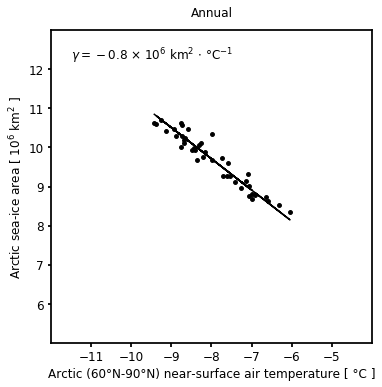

In [5]:
plt.figure(figsize=(5.75,5.75))
x=np.nanmean(obs_tas[:,:],axis=0)
y=np.nanmean(obs_sia[:,:],axis=0)
plt.scatter(x,y,s=15,c=lighten_color('k', amount=1),label='observations',zorder=0)
slope, intercept=tls_regression(y,x,np.arange(1,len(x)+1,1))
plt.plot(x,x*slope+intercept,c='k')
plt.xlim(-12,-4)
plt.ylim(5,13)
plt.yticks(np.arange(6,13,1))
plt.xticks(np.arange(-11,-4,1))
plt.text(-11.5,12.25,'$\gamma = -$'+str(abs(round(slope,2))) + ' $\\times$ 10$^6$ km$^2$ $\cdot$ °C$^{-1}$')
plt.ylabel('Arctic sea-ice area [ 10$^6$ km$^2$ ]')
plt.title('Annual',fontsize=12,y=1.025)
plt.xlabel('Arctic (60°N-90°N) near-surface air temperature [ °C ]')

ax=plt.gca()
plt.setp(ax.spines.values(), linewidth=1.75)
ax.xaxis.set_tick_params(width=1.75)
ax.yaxis.set_tick_params(width=1.75)
plt.rcParams.update({'font.size':12})
plt.savefig('figures/fig1a.pdf')

In [6]:
sia_c = np.nanmean(np.nanmean(obs_sia[:,:],axis=0),axis=0)
tas_c = np.nanmean(np.nanmean(obs_tas[:,:],axis=0),axis=0)
tas_f = np.nanmean(obs_tas[:,:],axis=0)
slope, intercept=tls_regression(np.nanmean(obs_sia[:,:],axis=0),np.nanmean(obs_tas[:,:],axis=0),np.arange(1979,2021,1))
ann_sia_p = sia_c + slope*(tas_f - tas_c)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


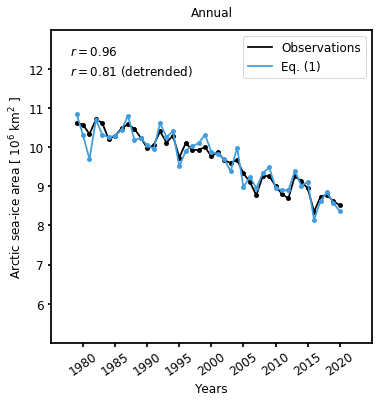

In [7]:
x=np.nanmean(obs_sia[:,:],axis=0)
y=ann_sia_p
plt.figure(figsize=(5.75,5.75))
plt.plot(np.arange(1979,2021,1),x,color='k',lw=1.75,label='Observations',zorder=0)
plt.scatter(np.arange(1979,2021,1),x,s=15,c=lighten_color('k', amount=1),zorder=0)
plt.plot(np.arange(1979,2021,1),y,color=lighten_color('C0',0.75),lw=1.75,label='Eq. (1)',zorder=1)
plt.scatter(np.arange(1979,2021,1),y,s=15,c=lighten_color('C0', amount=0.75),zorder=1)

plt.ylim(5,13)
plt.yticks(np.arange(6,13,1))
plt.xlim(1975,2025)
plt.xticks(np.arange(1980,2025,5),rotation=35)
plt.xlabel('Years')
plt.ylabel('Arctic sea-ice area [ 10$^6$ km$^2$ ]')
plt.title('Annual',fontsize=12,y=1.025)
cor_val = np.corrcoef(y,x)[0][-1]
plt.text(1978,12.35,'$r = ${:.2f}'.format(round(cor_val,2)))
cor_val = np.corrcoef(signal.detrend(y),signal.detrend(x))[0][-1]
plt.text(1978,11.85,'$r =$' + str(round(cor_val,2)) +  ' (detrended)')
plt.legend(loc='upper right')

ax=plt.gca()
plt.setp(ax.spines.values(), linewidth=1.75)
ax.xaxis.set_tick_params(width=1.75)
ax.yaxis.set_tick_params(width=1.75)
plt.rcParams.update({'font.size':12})
plt.savefig('figures/fig1b.pdf')

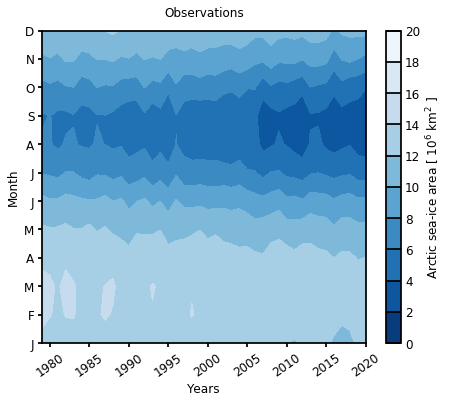

In [8]:
plt.figure(figsize=(7.25,5.75))

plt.contourf(np.arange(1979,2021,1),np.arange(0,12,1),obs_sia,np.arange(0,22,2),cmap='Blues_r')
cb=plt.colorbar()
cb.ax.tick_params(width = 1.75,direction='in',length=15)
cb.outline.set_linewidth(1.75)
cb.set_ticks(np.arange(0,22,2))
cb.set_label('Arctic sea-ice area [ 10$^6$ km$^2$ ]')
plt.title('Observations',fontsize=12,y=1.025)
plt.xlim(1979,2020)
plt.yticks(np.arange(0,12,1),['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xticks(np.arange(1980,2025,5),rotation=35)
plt.xlabel('Years')
plt.ylabel('Month')

ax=plt.gca()
plt.setp(ax.spines.values(), linewidth=1.75)
ax.xaxis.set_tick_params(width=1.75,length=4)
ax.yaxis.set_tick_params(width=1.75,length=4)
plt.rcParams.update({'font.size':12})
plt.savefig('figures/fig1c.pdf')

In [9]:
mon_sia_p = np.zeros((12,42))
for mon in range(12):
    sia_c = np.nanmean(obs_sia[mon,:])
    tas_c = np.nanmean(obs_tas[mon,:])
    tas_f = obs_tas[mon,:]
    slope = obs_gamma[mon]
    mon_sia_p[mon,:] = sia_c + slope*(tas_f - tas_c)

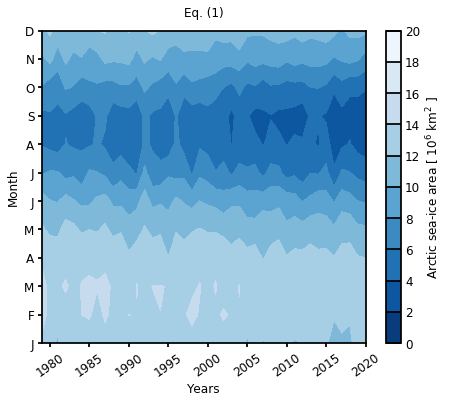

In [10]:
plt.figure(figsize=(7.25,5.75))

plt.contourf(np.arange(1979,2021,1),np.arange(0,12,1),mon_sia_p,np.arange(0,22,2),cmap='Blues_r')
cb=plt.colorbar()
cb.ax.tick_params(width = 1.75,direction='in',length=15)
cb.outline.set_linewidth(1.75)
cb.set_ticks(np.arange(0,22,2))
cb.set_label('Arctic sea-ice area [ 10$^6$ km$^2$ ]')
plt.title('Eq. (1)',fontsize=12,y=1.025)
plt.xlim(1979,2020)
plt.yticks(np.arange(0,12,1),['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xticks(np.arange(1980,2025,5),rotation=35)
plt.xlabel('Years')
plt.ylabel('Month')

ax=plt.gca()
plt.setp(ax.spines.values(), linewidth=1.75)
ax.xaxis.set_tick_params(width=1.75,length=4)
ax.yaxis.set_tick_params(width=1.75,length=4)
plt.rcParams.update({'font.size':12})
plt.savefig('figures/fig1d.pdf')

#### Figure 2

In [11]:
file = sio.loadmat('mat_files/cmip/CMIP6_NH_SIA_SSP585.mat')
CMIP6_NH_SIA_SSP585 = file['CMIP6_NH_SIA_SSP585']

file = sio.loadmat('mat_files/cmip/CMIP6_N60_TAS_SSP585.mat')
CMIP6_N60_TAS_SSP585 = file['CMIP6_N60_TAS_SSP585']

file = sio.loadmat('mat_files/cmip/CMIP6_NH_SIA_SSP245.mat')
CMIP6_NH_SIA_SSP245 = file['CMIP6_NH_SIA_SSP245']

file = sio.loadmat('mat_files/cmip/CMIP6_N60_TAS_SSP245.mat')
CMIP6_N60_TAS_SSP245 = file['CMIP6_N60_TAS_SSP245']

file = sio.loadmat('mat_files/cmip/CMIP6_NH_SIA_SSP126.mat')
CMIP6_NH_SIA_SSP126 = file['CMIP6_NH_SIA_SSP126']

file = sio.loadmat('mat_files/cmip/CMIP6_N60_TAS_SSP126.mat')
CMIP6_N60_TAS_SSP126 = file['CMIP6_N60_TAS_SSP126']

file = sio.loadmat('mat_files/cmip/CanESM5_LE_NH_SIA_SSP585.mat')
CanESM5_LE_NH_SIA_SSP585 = file['CanESM5_LE_NH_SIA_SSP585']

file = sio.loadmat('mat_files/cmip/CanESM5_LE_NH_SIA_SSP245.mat')
CanESM5_LE_NH_SIA_SSP245 = file['CanESM5_LE_NH_SIA_SSP245']

file = sio.loadmat('mat_files/cmip/CanESM5_LE_NH_SIA_SSP126.mat')
CanESM5_LE_NH_SIA_SSP126 = file['CanESM5_LE_NH_SIA_SSP126']

real_model_names=("ACCESS-CM2","ACCESS-ESM1-5","BCC-CSM2-MR","CAMS-CSM1-0","CanESM5","CESM2","CESM2-WACCM",\
                  "CNRM-CM6-1-HR","CNRM-CM6-1","EC-Earth3","EC-Earth3-Veg","EC-Earth3-Veg-LR","FGOALS-f3-L",\
                  "FGOALS-g3","FIO-ESM-2-0","GFDL-ESM4","HadGEM3-GC31-LL","INM-CM4-8","INM-CM5-0","IPSL-CM6A-LR",\
                  "MIROC6","MIROC-ES2L","MPI-ESM1-2-HR","MPI-ESM1-2-LR","MRI-ESM2-0","NESM3","NorESM2-LM","NorESM2-MM","UKESM1-0-LL")

In [12]:
CMIP6_years = np.arange(1865,2101,1)
SSP585_CMIP6_month_sia = np.zeros((12,29,len(CMIP6_years)))
SSP585_CMIP6_month_tas = np.zeros((12,29,len(CMIP6_years)))
SSP245_CMIP6_month_sia = np.zeros((12,29,len(CMIP6_years)))
SSP245_CMIP6_month_tas = np.zeros((12,29,len(CMIP6_years)))
SSP126_CMIP6_month_sia = np.zeros((12,29,len(CMIP6_years)))
SSP126_CMIP6_month_tas = np.zeros((12,29,len(CMIP6_years)))

for i in range(12):
    mon = i
    for k in range(len(CMIP6_years)):
        SSP585_CMIP6_month_sia[i,:,k] = CMIP6_NH_SIA_SSP585[:,mon]/1e12
        SSP585_CMIP6_month_tas[i,:,k] = CMIP6_N60_TAS_SSP585[:,mon]
        
        SSP245_CMIP6_month_sia[i,:,k] = CMIP6_NH_SIA_SSP245[:,mon]/1e12
        SSP245_CMIP6_month_tas[i,:,k] = CMIP6_N60_TAS_SSP245[:,mon]
        
        SSP126_CMIP6_month_sia[i,:,k] = CMIP6_NH_SIA_SSP126[:,mon]/1e12
        SSP126_CMIP6_month_tas[i,:,k] = CMIP6_N60_TAS_SSP126[:,mon]
        
        mon=mon+12

In [13]:
SSP585_sia_p = np.zeros((29,12,236))
SSP585_sia_r = np.zeros((29,12,236))

for mod in range(29):
    for mon in range(12):
        for ti in range(236):
            sia_real = SSP585_CMIP6_month_sia[mon,mod,:]
            sia_c = np.nanmean(SSP585_CMIP6_month_sia[mon,mod,114:156],axis=0)
            tas_c = np.nanmean(SSP585_CMIP6_month_tas[mon,mod,114:156],axis=0)
            tas_f = SSP585_CMIP6_month_tas[mon,mod,ti]
            y=SSP585_CMIP6_month_sia[mon,mod,114:]
            x=SSP585_CMIP6_month_tas[mon,mod,114:]
            t=np.arange(1,len(x)+1,1)
            slope, intercept, = tls_regression(y[y>1],x[y>1],t[y>1])
            SSP585_sia_p[mod,mon,ti] = sia_c + slope*(tas_f - tas_c)
            SSP585_sia_r[mod,mon,:] = sia_real 
            
SSP585_sia_p[SSP585_sia_p<0]=0

In [14]:
var = np.zeros((12,236))
for mon in range(12):
    for ti in range(236):
        x=SSP585_sia_p[:,mon,ti]
        y=SSP585_sia_r[:,mon,ti]
        var[mon,ti] = np.corrcoef(x,y)[0][-1]**2 * 100

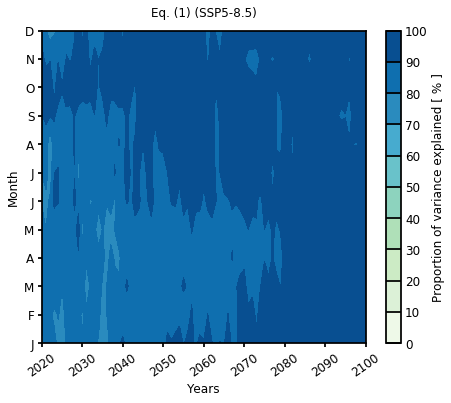

In [15]:
plt.figure(figsize=(7.25,5.75))

cmap='GnBu'
plt.contourf(np.arange(1865,2101,1),np.arange(0,12,1),var,np.arange(0,110,10),cmap=cmap)
cb=plt.colorbar()
cb.ax.tick_params(width = 1.75,direction='in',length=15)
cb.outline.set_linewidth(1.75)
cb.set_ticks(np.arange(0,110,10))
cb.set_label('Proportion of variance explained [ % ]')


plt.xlim(2020,2100)
plt.yticks(np.arange(0,12,1),['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xticks(np.arange(2020,2110,10),rotation=35)

plt.xlabel('Years')
plt.ylabel('Month')
plt.title('Eq. (1) (SSP5-8.5)',fontsize=12,y=1.025)

ax=plt.gca()
plt.setp(ax.spines.values(), linewidth=1.75)
ax.xaxis.set_tick_params(width=1.75,length=4)
ax.yaxis.set_tick_params(width=1.75,length=4)
plt.rcParams.update({'font.size':12})
plt.savefig('figures/fig2a.pdf')

In [16]:
sia_p_tf_tc_var = np.zeros((29,12,236))
for mod in range(29):
    for mon in range(12):
        for ti in range(236):
            sia_c = np.nanmean(np.nanmean(SSP585_CMIP6_month_sia[mon,:,114:156],axis=0),axis=0)
            tas_c = np.nanmean(SSP585_CMIP6_month_tas[mon,mod,114:156],axis=0)
            tas_f = SSP585_CMIP6_month_tas[mon,mod,ti]
            y=np.nanmean(SSP585_CMIP6_month_sia[mon,:,114:],axis=0)
            x=np.nanmean(SSP585_CMIP6_month_tas[mon,:,114:],axis=0)
            t=np.arange(1,len(x)+1,1)
            slope, intercept, = tls_regression(y[y>1],x[y>1],t[y>1])
            sia_p_tf_tc_var[mod,mon,ti] = sia_c + slope*(tas_f - tas_c)
            
sia_p_tf_tc_var[sia_p_tf_tc_var<0]=0

In [ ]:
sia_p_ec_var = np.zeros((29,12,236))
for mod in range(29):
    for mon in range(12):
        for ti in range(236):
            sia_c = np.nanmean(SSP585_CMIP6_month_sia[mon,mod,114:156],axis=0)
            tas_c = np.nanmean(np.nanmean(SSP585_CMIP6_month_tas[mon,:,114:156],axis=0),axis=0)
            tas_f = np.nanmean(SSP585_CMIP6_month_tas[mon,:,ti],axis=0)
            y=np.nanmean(SSP585_CMIP6_month_sia[mon,:,114:],axis=0)
            x=np.nanmean(SSP585_CMIP6_month_tas[mon,:,114:],axis=0)
            t=np.arange(1,len(x)+1,1)
            slope, intercept, = tls_regression(y[y>1],x[y>1],t[y>1])
            sia_p_ec_var[mod,mon,ti] = sia_c + slope*(tas_f - tas_c)
            
sia_p_ec_var[sia_p_ec_var<0]=0

In [ ]:
sia_p_de_dt_var = np.zeros((29,12,236))
for mod in range(29):
    for mon in range(12):
        for ti in range(236):
            sia_c = np.nanmean(np.nanmean(SSP585_CMIP6_month_sia[mon,:,114:156],axis=0),axis=0)
            tas_c = np.nanmean(np.nanmean(SSP585_CMIP6_month_tas[mon,:,114:156],axis=0),axis=0)
            tas_f = np.nanmean(SSP585_CMIP6_month_tas[mon,:,ti],axis=0)
            y=SSP585_CMIP6_month_sia[mon,mod,114:]
            x=SSP585_CMIP6_month_tas[mon,mod,114:]
            t=np.arange(1,len(x)+1,1)
            slope, intercept, = tls_regression(y[y>1],x[y>1],t[y>1])
            sia_p_de_dt_var[mod,mon,ti] = sia_c + slope*(tas_f - tas_c)
            
sia_p_de_dt_var[sia_p_de_dt_var<0]=0

In [ ]:
ec_var=np.zeros((12,236))
de_dt_var=np.zeros((12,236))
tf_tc_var=np.zeros((12,236))
for mon in range(12):
    var1=np.std(sia_p_ec_var[:,mon,:],axis=0)**2
    var2=np.std(sia_p_de_dt_var[:,mon,:],axis=0)**2
    var3=np.std(sia_p_tf_tc_var[:,mon,:],axis=0)**2
    total=var1+var2+var3
    ec_var[mon,:]=var1/total*100
    de_dt_var[mon,:]=var2/total*100
    tf_tc_var[mon,:]=var3/total*100

In [ ]:
plt.figure(figsize=(7.25,5.75))

cmap='GnBu'
plt.contourf(np.arange(1865,2101,1),np.arange(0,12,1),ec_var,np.arange(0,110,10),cmap=cmap)
cb=plt.colorbar()
cb.ax.tick_params(width = 1.75,direction='in',length=15)
cb.outline.set_linewidth(1.75)
cb.set_ticks(np.arange(0,110,10))
cb.set_label('Fractional contribution to total variance [ % ]')
plt.xlim(2020,2100)
plt.yticks(np.arange(0,12,1),['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xticks(np.arange(2020,2110,10),rotation=35)
plt.xlabel('Years')
plt.ylabel('Month')
plt.title('$\overline{A}_c$ (SSP5-8.5)',fontsize=12,y=1.025)

ax=plt.gca()
plt.setp(ax.spines.values(), linewidth=1.75)
ax.xaxis.set_tick_params(width=1.75,length=4)
ax.yaxis.set_tick_params(width=1.75,length=4)
plt.rcParams.update({'font.size':12})
plt.savefig('figures/fig2b.pdf')

In [ ]:
plt.figure(figsize=(7.25,5.75))

cmap='GnBu'
plt.contourf(np.arange(1865,2101,1),np.arange(0,12,1),de_dt_var,np.arange(0,110,10),cmap=cmap)
cb=plt.colorbar()
cb.ax.tick_params(width = 1.75,direction='in',length=15)
cb.outline.set_linewidth(1.75)
cb.set_ticks(np.arange(0,110,10))
cb.set_label('Fractional contribution to total variance [ % ]')


plt.xlim(2020,2100)
plt.yticks(np.arange(0,12,1),['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xticks(np.arange(2020,2110,10),rotation=35)
plt.xlabel('Years')
plt.ylabel('Month')
plt.title('$\gamma$ (SSP5-8.5)',fontsize=12,y=1.025)

ax=plt.gca()
plt.setp(ax.spines.values(), linewidth=1.75)
ax.xaxis.set_tick_params(width=1.75,length=4)
ax.yaxis.set_tick_params(width=1.75,length=4)
plt.rcParams.update({'font.size':12})
plt.savefig('figures/fig2c.pdf')

In [ ]:
plt.figure(figsize=(7.25,5.75))

cmap='GnBu'
plt.contourf(np.arange(1865,2101,1),np.arange(0,12,1),tf_tc_var,np.arange(0,110,10),cmap=cmap)
cb=plt.colorbar()
cb.ax.tick_params(width = 1.75,direction='in',length=15)
cb.outline.set_linewidth(1.75)
cb.set_ticks(np.arange(0,110,10))
cb.set_label('Fractional contribution to total variance [ % ]')


plt.xlim(2020,2100)
plt.yticks(np.arange(0,12,1),['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xticks(np.arange(2020,2110,10),rotation=35)
plt.xlabel('Years')
plt.ylabel('Month')
plt.title('$T(t)-\overline{T}_c$ (SSP5-8.5)',fontsize=12,y=1.025)

ax=plt.gca()
plt.setp(ax.spines.values(), linewidth=1.75)
ax.xaxis.set_tick_params(width=1.75,length=4)
ax.yaxis.set_tick_params(width=1.75,length=4)
plt.rcParams.update({'font.size':12})
plt.savefig('figures/fig2d.pdf')

#### Figure 3

In [ ]:
SSP585_sia_p_ec = np.zeros((29,12,236))
for mod in range(29):
    for mon in range(12):
        for ti in range(236):
            sia_c = np.nanmean(obs_sia[mon,:])
            tas_c = np.nanmean(SSP585_CMIP6_month_tas[mon,mod,114:156],axis=0)
            tas_f = SSP585_CMIP6_month_tas[mon,mod,ti]
            y=SSP585_CMIP6_month_sia[mon,mod,114:]
            x=SSP585_CMIP6_month_tas[mon,mod,114:]
            t=np.arange(1,len(x)+1,1)
            slope, intercept = tls_regression(y[y>1],x[y>1],t[y>1])
            SSP585_sia_p_ec[mod,mon,ti] = sia_c + slope*(tas_f - tas_c)
            
SSP585_sia_p_ec[SSP585_sia_p_ec<0]=0

In [ ]:
SSP585_sia_p_ec_da_dt = np.zeros((29,12,236))
for mod in range(29):
    for mon in range(12):
        for ti in range(236):
            sia_c = np.nanmean(obs_sia[mon,:])
            tas_c = np.nanmean(SSP585_CMIP6_month_tas[mon,mod,114:156],axis=0)
            tas_f = SSP585_CMIP6_month_tas[mon,mod,ti]
            SSP585_sia_p_ec_da_dt[mod,mon,ti] = sia_c + obs_gamma[mon]*(tas_f - tas_c)
            
SSP585_sia_p_ec_da_dt[SSP585_sia_p_ec_da_dt<0]=0

In [ ]:
SSP585_da_dt_slope = np.zeros((29,12,236))
for mod in range(29):
    for mon in range(12):
        beg=114
        end=156
        ind=155
        for ti in range(81):
            y=SSP585_CMIP6_month_sia[mon,mod,beg:end]
            x=SSP585_CMIP6_month_tas[mon,mod,beg:end]
            x=x[y>1]
            y=y[y>1]
            t=np.arange(1,len(x)+1,1)
            slope, intercept = tls_regression(y[y>1],x[y>1],t[y>1])
            SSP585_da_dt_slope[mod,mon,ind] = slope
            beg=beg
            end=end+1
            ind=ind+1
SSP585_da_dt_slope[SSP585_da_dt_slope==0]=np.nan

In [ ]:
SSP585_gamma_gcm_obs = np.zeros((12,236))
for mon in range(12):
        gamma_gcm  = np.nanmean(SSP585_da_dt_slope[:,mon,:],axis=0)
        gamma = gamma_gcm/gamma_gcm[155]*(obs_gamma[mon])
        SSP585_gamma_gcm_obs[mon,:]=gamma

In [ ]:
SSP585_sia_p_ec_da_dt_c = np.zeros((29,12,236))
for mod in range(29):
    for mon in range(12):
        for ti in range(236):
            sie_c = np.nanmean(obs_sia[mon,:])
            tas_c = np.nanmean(SSP585_CMIP6_month_tas[mon,mod,114:156],axis=0)
            tas_f = SSP585_CMIP6_month_tas[mon,mod,ti]
            gamma = SSP585_gamma_gcm_obs[mon,:]
            SSP585_sia_p_ec_da_dt_c[mod,mon,ti] = sie_c + gamma[ti]*(tas_f - tas_c)
            
SSP585_sia_p_ec_da_dt_c[SSP585_sia_p_ec_da_dt_c<0]=0

In [ ]:
years=np.arange(1865,2101,1)
SSP585_sia_p_cdf = ice_free_date(SSP585_sia_p,years)
SSP585_sia_p_ec_cdf = ice_free_date(SSP585_sia_p_ec,years)
SSP585_sia_p_ec_da_dt_cdf = ice_free_date(SSP585_sia_p_ec_da_dt,years)
SSP585_sia_p_ec_da_dt_c_cdf = ice_free_date(SSP585_sia_p_ec_da_dt_c,years)
years=np.arange(1950,2101,1)
years=np.arange(2015,2101,1)
SSP585_sia_lens_cdf = ice_free_date(CanESM5_LE_NH_SIA_SSP585,years)

In [ ]:
plt.figure(figsize=(6,8.25))

x = np.arange(1861,2201,1)
plt.plot([2000,2100],[10,10],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[33,33],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[66,66],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[90,90],c='darkgrey',lw=1,zorder=0)

y=SSP585_sia_p_cdf[8,:]
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)

ind=np.where(yn>=66)[0][0]
plt.plot(x,y,c='k',label='Eq. (1)')
plt.plot(xn[ind],yn[ind],'ko')
plt.plot([xn[ind],xn[ind]],[0,yn[ind]],'-',c='k',ls='--',lw=0.75,zorder=1)
plt.text(xn[ind]-3.25,25,str(int(round(xn[ind]))),bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),zorder=6)

y=SSP585_sia_p_ec_cdf[8,:]
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)

ind=np.where(yn>=66)[0][0]
plt.plot(x,y,c='C0',label='$\overline{A}_c$ (observations)')
plt.plot(xn[ind],yn[ind],'o',c='C0')
plt.plot([xn[ind],xn[ind]],[0,yn[ind]],'-',c='C0',ls='--',lw=0.75,zorder=1)
plt.text(xn[ind]-3.25,19,str(int(round(xn[ind]))),c='C0',bbox=dict(facecolor='white', edgecolor='C0', boxstyle='round,pad=0.2'),zorder=6)

y=SSP585_sia_p_ec_da_dt_cdf[8,:]
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)

ind=np.where(yn>=66)[0][0]
plt.plot(x,y,c='C4',label='$\gamma$ (observations)')
plt.plot(xn[ind],yn[ind],'o',c='C4')
plt.plot([xn[ind],xn[ind]],[0,yn[ind]],'-',c='C4',ls='--',lw=0.75,zorder=1)
plt.text(xn[ind]-3.25,13,str(int(round(xn[ind]))),c='C4',bbox=dict(facecolor='white', edgecolor='C4', boxstyle='round,pad=0.2'),zorder=6)

y=SSP585_sia_p_ec_da_dt_c_cdf[8,:]
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)

ind=np.where(yn>=66)[0][0]
plt.plot(x,y,c='C3',label='$\gamma$ (constrained)')
plt.plot(xn[ind],yn[ind],'o',c='C3')
plt.plot([xn[ind],xn[ind]],[0,yn[ind]],'-',c='C3',ls='--',lw=0.75,zorder=1)
plt.text(xn[ind]-3.25,5,str(int(round(xn[ind]))),c='C3',bbox=dict(facecolor='white', edgecolor='C3', boxstyle='round,pad=0.2'),zorder=6)

yi=SSP585_sia_lens_cdf[8,:]
fi = interpolate.interp1d(x, yi)
xni = np.linspace(1861,2200,100000)
yni = fi(xni)
ind1=np.where(yni>=50-49.8)[0][0]
ind2=np.where(yni>=50+49.8)[0][0]

int_range = (xni[ind2]-xni[ind1])/2
xfi=np.linspace(xn[ind]-int_range,xn[ind]+int_range,10)
yf1=np.zeros((10))
yf2=np.zeros((10))+2.5
plt.fill_between(xfi,yf2,yf1,color=lighten_color('C3', amount=1),alpha=1,zorder=3,label='internal variability')

plt.text(2080-2,4,'very unlikely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2086.75-2,20,'unlikely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2085.5-2,46,'as likely \n as not',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2090.15-2,77.5,'likely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2083.5-2,94,'very likely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)

plt.xlim(2020,2100)
ax=plt.gca()
lgd=ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2,borderpad=1)
frame = lgd.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
frame.set_linewidth(1.75)
plt.xticks(np.arange(2020,2110,10),rotation=35)
plt.ylim(0,100)
plt.yticks(np.arange(0,110,10))
plt.ylabel('Probability of an "ice free" Arctic [ % ]')
plt.xlabel('Years')
plt.title('September (SSP5-8.5)',fontsize=13,y=1.025)
ax=plt.gca()

plt.setp(ax.spines.values(), linewidth=1.75,zorder=7)
ax.xaxis.set_tick_params(width=1.75,length=4)
ax.yaxis.set_tick_params(width=1.75,length=4)
plt.rcParams.update({'font.size':13})
plt.tight_layout()
plt.savefig('figures/fig3a.pdf',bbox_inches='tight')

In [ ]:
SSP245_sia_p = np.zeros((29,12,236))

for mod in range(29):
    for mon in range(12):
        for ti in range(236):
            sia_c = np.nanmean(SSP245_CMIP6_month_sia[mon,mod,114:156],axis=0)
            tas_c = np.nanmean(SSP245_CMIP6_month_tas[mon,mod,114:156],axis=0)
            tas_f = SSP245_CMIP6_month_tas[mon,mod,ti]
            y=SSP245_CMIP6_month_sia[mon,mod,114:]
            x=SSP245_CMIP6_month_tas[mon,mod,114:]
            t=np.arange(1,len(x)+1,1)
            slope, intercept, = tls_regression(y[y>1],x[y>1],t[y>1])
            SSP245_sia_p[mod,mon,ti] = sia_c + slope*(tas_f - tas_c)
            
SSP245_sia_p[SSP245_sia_p<0]=0

In [ ]:
SSP245_sia_p_ec = np.zeros((29,12,236))
for mod in range(29):
    for mon in range(12):
        for ti in range(236):
            sia_c = np.nanmean(obs_sia[mon,:])
            tas_c = np.nanmean(SSP245_CMIP6_month_tas[mon,mod,114:156],axis=0)
            tas_f = SSP245_CMIP6_month_tas[mon,mod,ti]
            y=SSP245_CMIP6_month_sia[mon,mod,114:]
            x=SSP245_CMIP6_month_tas[mon,mod,114:]
            t=np.arange(1,len(x)+1,1)
            slope, intercept = tls_regression(y[y>1],x[y>1],t[y>1])
            SSP245_sia_p_ec[mod,mon,ti] = sia_c + slope*(tas_f - tas_c)
            
SSP245_sia_p_ec[SSP245_sia_p_ec<0]=0

In [ ]:
SSP245_sia_p_ec_da_dt = np.zeros((29,12,236))
for mod in range(29):
    for mon in range(12):
        for ti in range(236):
            sia_c = np.nanmean(obs_sia[mon,:])
            tas_c = np.nanmean(SSP245_CMIP6_month_tas[mon,mod,114:156],axis=0)
            tas_f = SSP245_CMIP6_month_tas[mon,mod,ti]
            SSP245_sia_p_ec_da_dt[mod,mon,ti] = sia_c + obs_gamma[mon]*(tas_f - tas_c)
            
SSP245_sia_p_ec_da_dt[SSP245_sia_p_ec_da_dt<0]=0

In [ ]:
SSP245_da_dt_slope = np.zeros((29,12,236))
for mod in range(29):
    for mon in range(12):
        beg=114
        end=156
        ind=155
        for ti in range(81):
            y=SSP245_CMIP6_month_sia[mon,mod,beg:end]
            x=SSP245_CMIP6_month_tas[mon,mod,beg:end]
            x=x[y>1]
            y=y[y>1]
            t=np.arange(1,len(x)+1,1)
            slope, intercept = tls_regression(y[y>1],x[y>1],t[y>1])
            SSP245_da_dt_slope[mod,mon,ind] = slope
            beg=beg
            end=end+1
            ind=ind+1
SSP245_da_dt_slope[SSP245_da_dt_slope==0]=np.nan

In [ ]:
SSP245_gamma_gcm_obs = np.zeros((12,236))
for mon in range(12):
        gamma_gcm  = np.nanmean(SSP245_da_dt_slope[:,mon,:],axis=0)
        gamma = gamma_gcm/gamma_gcm[155]*(obs_gamma[mon])
        SSP245_gamma_gcm_obs[mon,:]=gamma

In [ ]:
SSP245_sia_p_ec_da_dt_c = np.zeros((29,12,236))
for mod in range(29):
    for mon in range(12):
        for ti in range(236):
            sie_c = np.nanmean(obs_sia[mon,:])
            tas_c = np.nanmean(SSP245_CMIP6_month_tas[mon,mod,114:156],axis=0)
            tas_f = SSP245_CMIP6_month_tas[mon,mod,ti]
            gamma = SSP245_gamma_gcm_obs[mon,:]
            SSP245_sia_p_ec_da_dt_c[mod,mon,ti] = sie_c + gamma[ti]*(tas_f - tas_c)
            
SSP245_sia_p_ec_da_dt_c[SSP245_sia_p_ec_da_dt_c<0]=0

In [ ]:
years=np.arange(1865,2101,1)
SSP245_sia_p_cdf = ice_free_date(SSP245_sia_p,years)
SSP245_sia_p_ec_cdf = ice_free_date(SSP245_sia_p_ec,years)
SSP245_sia_p_ec_da_dt_cdf = ice_free_date(SSP245_sia_p_ec_da_dt,years)
SSP245_sia_p_ec_da_dt_c_cdf = ice_free_date(SSP245_sia_p_ec_da_dt_c,years)
SSP245_sia_lens_cdf = ice_free_date(CanESM5_LE_NH_SIA_SSP245,years)

In [ ]:
plt.figure(figsize=(6,8.25))

x = np.arange(1861,2201,1)
y=SSP245_sia_p_cdf[8,:]
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)

ind=np.where(yn>=66)[0][0]
plt.plot(x,y,c='k',label='Eq. (1)')
plt.plot(xn[ind],yn[ind],'ko')
plt.plot([xn[ind],xn[ind]],[0,yn[ind]],'-',c='k',ls='--',lw=0.75,zorder=0)
plt.text(xn[ind]-3.25,25,str(int(round(xn[ind]))),bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),zorder=6)

y=SSP245_sia_p_ec_cdf[8,:]
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)

ind=np.where(yn>=66)[0][0]
plt.plot(x,y,c='C0',label='$\overline{A}_c$ (observations)')
plt.plot(xn[ind],yn[ind],'o',c='C0')
plt.plot([xn[ind],xn[ind]],[0,yn[ind]],'-',c='C0',ls='--',lw=0.75,zorder=0)
plt.text(xn[ind]-3.25,19,str(int(round(xn[ind]))),c='C0',bbox=dict(facecolor='white', edgecolor='C0', boxstyle='round,pad=0.2'),zorder=6)

y=SSP245_sia_p_ec_da_dt_cdf[8,:]
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)

ind=np.where(yn>=66)[0][0]
plt.plot(x,y,c='C4',label='$\gamma$ (observations)')
plt.plot(xn[ind],yn[ind],'o',c='C4')
plt.plot([xn[ind],xn[ind]],[0,yn[ind]],'-',c='C4',ls='--',lw=0.75,zorder=0)
plt.text(xn[ind]-3.25,13,str(int(round(xn[ind]))),c='C4',bbox=dict(facecolor='white', edgecolor='C4', boxstyle='round,pad=0.2'),zorder=6)

y=SSP245_sia_p_ec_da_dt_c_cdf[8,:]
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)

ind=np.where(yn>=66)[0][0]
plt.plot(x,y,c='C3',label='$\gamma$ (evolution)')
plt.plot(xn[ind],yn[ind],'o',c='C3')
plt.plot([xn[ind],xn[ind]],[0,yn[ind]],'-',c='C3',ls='--',lw=0.75,zorder=0)
plt.text(xn[ind]-3.25,5,str(int(round(xn[ind]))),c='C3',bbox=dict(facecolor='white', edgecolor='C3', boxstyle='round,pad=0.2'),zorder=6)

yi=SSP245_sia_lens_cdf[8,:]
fi = interpolate.interp1d(x, yi)
xni = np.linspace(1861,2200,100000)
yni = fi(xni)
ind1=np.where(yni>=50-49.8)[0][0]
ind2=np.where(yni>=50+49.8)[0][0]

int_range = (xni[ind2]-xni[ind1])/2
xfi=np.linspace(xn[ind]-int_range,xn[ind]+int_range,10)
yf1=np.zeros((10))
yf2=np.zeros((10))+2.5
plt.fill_between(xfi,yf2,yf1,color=lighten_color('C3', amount=1),alpha=1,zorder=3,label='internal variability')

plt.plot([2000,2100],[10,10],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[33,33],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[66,66],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[90,90],c='darkgrey',lw=1,zorder=0)

plt.text(2080-2,4,'very unlikely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2086.75-2,20,'unlikely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2085.5-2,46,'as likely \n as not',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2090.15-2,77.5,'likely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2083.5-2,94,'very likely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)


plt.xlim(2020,2100)
ax=plt.gca()
lgd=ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2,borderpad=1)
frame = lgd.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
frame.set_linewidth(1.75)
plt.xticks(np.arange(2020,2110,10),rotation=35)
plt.ylim(0,100)
plt.yticks(np.arange(0,110,10))
plt.ylabel('Probability of an "ice free" Arctic [ % ]')
plt.xlabel('Years')
plt.title('September (SSP2-4.5)',fontsize=13,y=1.025)

ax=plt.gca()
plt.setp(ax.spines.values(), linewidth=1.75,zorder=7)
ax.xaxis.set_tick_params(width=1.75,length=4)
ax.yaxis.set_tick_params(width=1.75,length=4)
plt.rcParams.update({'font.size':13})
plt.tight_layout()
plt.savefig('figures/fig3b.pdf',bbox_inches='tight')

In [ ]:
SSP126_sia_p = np.zeros((29,12,236))

for mod in range(29):
    for mon in range(12):
        for ti in range(236):
            sia_c = np.nanmean(SSP126_CMIP6_month_sia[mon,mod,114:156],axis=0)
            tas_c = np.nanmean(SSP126_CMIP6_month_tas[mon,mod,114:156],axis=0)
            tas_f = SSP126_CMIP6_month_tas[mon,mod,ti]
            y=SSP126_CMIP6_month_sia[mon,mod,114:]
            x=SSP126_CMIP6_month_tas[mon,mod,114:]
            t=np.arange(1,len(x)+1,1)
            slope, intercept, = tls_regression(y[y>1],x[y>1],t[y>1])
            SSP126_sia_p[mod,mon,ti] = sia_c + slope*(tas_f - tas_c)
            
SSP126_sia_p[SSP126_sia_p<0]=0

In [ ]:
SSP126_sia_p_ec = np.zeros((29,12,236))
for mod in range(29):
    for mon in range(12):
        for ti in range(236):
            sia_c = np.nanmean(obs_sia[mon,:])
            tas_c = np.nanmean(SSP126_CMIP6_month_tas[mon,mod,114:156],axis=0)
            tas_f = SSP126_CMIP6_month_tas[mon,mod,ti]
            y=SSP126_CMIP6_month_sia[mon,mod,114:]
            x=SSP126_CMIP6_month_tas[mon,mod,114:]
            t=np.arange(1,len(x)+1,1)
            slope, intercept = tls_regression(y[y>1],x[y>1],t[y>1])
            SSP126_sia_p_ec[mod,mon,ti] = sia_c + slope*(tas_f - tas_c)
            
SSP126_sia_p_ec[SSP126_sia_p_ec<0]=0

In [ ]:
SSP126_sia_p_ec_da_dt = np.zeros((29,12,236))
for mod in range(29):
    for mon in range(12):
        for ti in range(236):
            sia_c = np.nanmean(obs_sia[mon,:])
            tas_c = np.nanmean(SSP126_CMIP6_month_tas[mon,mod,114:156],axis=0)
            tas_f = SSP126_CMIP6_month_tas[mon,mod,ti]
            SSP126_sia_p_ec_da_dt[mod,mon,ti] = sia_c + obs_gamma[mon]*(tas_f - tas_c)
            
SSP126_sia_p_ec_da_dt[SSP126_sia_p_ec_da_dt<0]=0

In [ ]:
SSP126_da_dt_slope = np.zeros((29,12,236))
for mod in range(29):
    for mon in range(12):
        beg=114
        end=156
        ind=155
        for ti in range(81):
            y=SSP126_CMIP6_month_sia[mon,mod,beg:end]
            x=SSP126_CMIP6_month_tas[mon,mod,beg:end]
            x=x[y>1]
            y=y[y>1]
            t=np.arange(1,len(x)+1,1)
            slope, intercept = tls_regression(y[y>1],x[y>1],t[y>1])
            SSP126_da_dt_slope[mod,mon,ind] = slope
            beg=beg
            end=end+1
            ind=ind+1
SSP126_da_dt_slope[SSP126_da_dt_slope==0]=np.nan

In [ ]:
SSP126_gamma_gcm_obs = np.zeros((12,236))
for mon in range(12):
        gamma_gcm  = np.nanmean(SSP126_da_dt_slope[:,mon,:],axis=0)
        gamma = gamma_gcm/gamma_gcm[155]*(obs_gamma[mon])
        SSP126_gamma_gcm_obs[mon,:]=gamma

In [ ]:
SSP126_sia_p_ec_da_dt_c = np.zeros((29,12,236))
for mod in range(29):
    for mon in range(12):
        for ti in range(236):
            sie_c = np.nanmean(obs_sia[mon,:])
            tas_c = np.nanmean(SSP126_CMIP6_month_tas[mon,mod,114:156],axis=0)
            tas_f = SSP126_CMIP6_month_tas[mon,mod,ti]
            gamma = SSP126_gamma_gcm_obs[mon,:]
            SSP126_sia_p_ec_da_dt_c[mod,mon,ti] = sie_c + gamma[ti]*(tas_f - tas_c)
            
SSP126_sia_p_ec_da_dt_c[SSP126_sia_p_ec_da_dt_c<0]=0

In [ ]:
years=np.arange(1865,2101,1)
SSP126_sia_p_cdf = ice_free_date(SSP126_sia_p,years)
SSP126_sia_p_ec_cdf = ice_free_date(SSP126_sia_p_ec,years)
SSP126_sia_p_ec_da_dt_cdf = ice_free_date(SSP126_sia_p_ec_da_dt,years)
SSP126_sia_p_ec_da_dt_c_cdf = ice_free_date(SSP126_sia_p_ec_da_dt_c,years)
SSP126_sia_lens_cdf = ice_free_date(CanESM5_LE_NH_SIA_SSP126,years)

In [ ]:
plt.figure(figsize=(6,8.25))

x = np.arange(1861,2201,1)
plt.plot([2000,2100],[10,10],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[33,33],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[66,66],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[90,90],c='darkgrey',lw=1,zorder=0)

y=SSP126_sia_p_cdf[8,:]
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)

plt.plot(x,y,c='k',label='Eq. (1)')

y=SSP126_sia_p_ec_cdf[8,:]
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)

plt.plot(x,y,c='C0',label='$\overline{A}_c$ (observations)')

y=SSP126_sia_p_ec_da_dt_cdf[8,:]
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)

plt.plot(x,y,c='C4',label='$\gamma$ (observations)')

y=SSP126_sia_p_ec_da_dt_c_cdf[8,:]
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)

ind=np.where(yn>=66)[0][0]
plt.plot(x,y,c='C3',label='$\gamma$ (constrained)')
plt.plot(xn[ind],yn[ind],'o',c='C3')
plt.plot([xn[ind],xn[ind]],[0,yn[ind]],'-',c='C3',ls='--',lw=0.75,zorder=2)
plt.text(xn[ind]-3.25,5,str(int(round(xn[ind]))),c='C3',bbox=dict(facecolor='white', edgecolor='C3', boxstyle='round,pad=0.2'),zorder=6)

yi=SSP126_sia_lens_cdf[8,:]
fi = interpolate.interp1d(x, yi)
xni = np.linspace(1861,2200,100000)
yni = fi(xni)
ind1=np.where(yni>=50-49.8)[0][0]
ind2=np.where(yni>=50+49.8)[0][0]

int_range = (xni[ind2]-xni[ind1])/2
xfi=np.linspace(xn[ind]-int_range,xn[ind]+int_range,10)
yf1=np.zeros((10))
yf2=np.zeros((10))+2.5
plt.fill_between(xfi,yf2,yf1,color=lighten_color('C3', amount=1),alpha=1,zorder=3,label='internal variability')

plt.text(2080-2,4,'very unlikely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.5),zorder=0,alpha=0.5)
plt.text(2086.75-2,20,'unlikely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2085.5-2,46,'as likely \n as not',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2090.15-2,77.5,'likely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2083.5-2,94,'very likely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)

plt.xlim(2020,2100)
ax=plt.gca()
lgd=ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2,borderpad=1)
frame = lgd.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
frame.set_linewidth(1.75)
plt.xticks(np.arange(2020,2110,10),rotation=35)
plt.ylim(0,100)
plt.yticks(np.arange(0,110,10))
plt.ylabel('Probability of an "ice free" Arctic [ % ]')
plt.xlabel('Years')
plt.title('September (SSP1-2.6)',fontsize=13,y=1.025)

ax=plt.gca()
plt.setp(ax.spines.values(), linewidth=1.75,zorder=7)
ax.xaxis.set_tick_params(width=1.75,length=4)
ax.yaxis.set_tick_params(width=1.75,length=4)
plt.rcParams.update({'font.size':13})
plt.tight_layout()
plt.savefig('figures/fig3c.pdf',bbox_inches='tight')

#### Figure 4

In [ ]:
plt.figure(figsize=(5.75,6.25))
x = np.arange(1861,2201,1)

y=SSP126_sia_p_cdf[6,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='k',ls=(0,(1,1)),label='SSP1-2.6, Eq. (1)',lw=1.35)


y=SSP245_sia_p_cdf[6,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='k',ls=(0,(5,1)),label='SSP2-4.5, Eq. (1)',lw=1.35)

y=SSP585_sia_p_cdf[6,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='k',label='SSP5-8.5, Eq. (1)',lw=1.25)

y=SSP126_sia_p_ec_da_dt_c_cdf[6,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='C3',ls=(0,(1,1)),label='SSP1-2.6, constrained',lw=1.35)

y=SSP245_sia_p_ec_da_dt_c_cdf[6,:]
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
ind=np.where(yn>=66)[0][0]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='C3',ls=(0,(5,1)),label='SSP2-4.5, constrained',lw=1.35)

y=SSP585_sia_p_ec_da_dt_c_cdf[6,:]
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
ind=np.where(yn>=66)[0][0]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='C3',label='SSP5-8.5, constrained',lw=1.35)

plt.plot(xn[ind],yn[ind],'o',c='C3')
plt.plot([xn[ind],xn[ind]],[0,yn[ind]],'-',c=lighten_color('C3', amount=0.5),ls='--',lw=0.75,zorder=0)


yi=SSP585_sia_lens_cdf[6,:]
fi = interpolate.interp1d(x, yi)
xni = np.linspace(1861,2200,100000)
yni = fi(xni)
ind1=np.where(yni>=50-49.8)[0][0]
ind2=np.where(yni>=50+49.8)[0][0]

int_range = (xni[ind2]-xni[ind1])/2
xfi=np.linspace(xn[ind]-int_range,xn[ind]+int_range,10)
yf1=np.zeros((10))
yf2=np.zeros((10))+2.5
plt.fill_between(xfi,yf2,yf1,color=lighten_color('C3', amount=1),alpha=1,zorder=3,label='internal variability')


plt.plot([2000,2100],[10,10],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[33,33],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[66,66],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[90,90],c='darkgrey',lw=1,zorder=0)
plt.text(2023,4,'very unlikely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2023,20,'unlikely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2023,46,'as likely \n as not',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)

plt.legend(loc='upper left',ncol=1)
plt.xlim(2020,2100)
ax=plt.gca()
plt.legend()
plt.xticks(np.arange(2020,2110,10),rotation=35)
plt.ylim(0,100)
plt.yticks(np.arange(0,110,10))
plt.ylabel('Probability of an "ice free" Arctic [ % ]')
plt.xlabel('Years')
plt.title('July',fontsize=12,y=1.025)

ax=plt.gca()
plt.setp(ax.spines.values(), linewidth=1.75,zorder=7)
ax.xaxis.set_tick_params(width=1.75,length=4)
ax.yaxis.set_tick_params(width=1.75,length=4)
plt.rcParams.update({'font.size':12})
plt.tight_layout()
plt.savefig('figures/fig4a.pdf',bbox_inches='tight')

In [ ]:
plt.figure(figsize=(5.75,6.25))
y=SSP126_sia_p_cdf[7,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='k',ls=(0,(1,1)),label='SSP1-2.6, Eq. 1',lw=1.35)

y=SSP245_sia_p_cdf[7,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='k',ls=(0,(5,1)),label='SSP2-4.5, Eq. 1',lw=1.35)

y=SSP585_sia_p_cdf[7,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='k',label='SSP5-8.5, Eq. 1',lw=1.35)

y=SSP126_sia_p_ec_da_dt_c_cdf[7,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='C3',ls=(0,(1,1)),label='SSP1-2.6, constrained',lw=1.35)

y=SSP245_sia_p_ec_da_dt_c_cdf[7,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='C3',ls=(0,(5,1)),label='SSP2-4.5, constrained',lw=1.35)

y=SSP585_sia_p_ec_da_dt_c_cdf[7,:]
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
ind=np.where(yn>=66)[0][0]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='C3',label='SSP5-8.5, constrained',lw=1.35)
plt.plot(xn[ind],yn[ind],'o',c='C3')
plt.plot([xn[ind],xn[ind]],[0,yn[ind]],'-',c=lighten_color('C3', amount=0.5),ls='--',lw=0.75,zorder=0)

yi=SSP585_sia_lens_cdf[7,:]
fi = interpolate.interp1d(x, yi)
xni = np.linspace(1861,2200,100000)
yni = fi(xni)
ind1=np.where(yni>=50-49.8)[0][0]
ind2=np.where(yni>=50+49.8)[0][0]

int_range = (xni[ind2]-xni[ind1])/2
xfi=np.linspace(xn[ind]-int_range,xn[ind]+int_range,10)
yf1=np.zeros((10))
yf2=np.zeros((10))+2.5
plt.fill_between(xfi,yf2,yf1,color=lighten_color('C3', amount=1),alpha=1,zorder=3,label='internal variability')

plt.plot([2000,2100],[10,10],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[33,33],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[66,66],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[90,90],c='darkgrey',lw=1,zorder=0)
plt.text(2023,4,'very unlikely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2023,20,'unlikely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2023,46,'as likely \n as not',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2023,77.5,'likely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2023,94,'very likely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)

plt.xlim(2020,2100)
ax=plt.gca()

plt.xticks(np.arange(2020,2110,10),rotation=35)
plt.ylim(0,100)
plt.yticks(np.arange(0,110,10))
plt.ylabel('Probability of an "ice free" Arctic [ % ]')
plt.xlabel('Years')
plt.title('August',fontsize=12,y=1.025)

ax=plt.gca()
plt.setp(ax.spines.values(), linewidth=1.75,zorder=7)
ax.xaxis.set_tick_params(width=1.75,length=4)
ax.yaxis.set_tick_params(width=1.75,length=4)
plt.rcParams.update({'font.size':12})
plt.tight_layout()
plt.savefig('figures/fig4b.pdf',bbox_inches='tight')

In [ ]:
plt.figure(figsize=(5.75,6.25))
y=SSP126_sia_p_cdf[8,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='k',ls=(0,(1,1)),label='SSP1-2.6, Eq. 1',lw=1.35)

y=SSP245_sia_p_cdf[8,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='k',ls=(0,(5,1)),label='SSP2-4.5, Eq. 1',lw=1.35)

y=SSP585_sia_p_cdf[8,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='k',label='SSP5-8.5, Eq. 1',lw=1.35)

y=SSP126_sia_p_ec_da_dt_c_cdf[8,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='C3',ls=(0,(1,1)),label='SSP1-2.6, constrained',lw=1.35)

y=SSP245_sia_p_ec_da_dt_c_cdf[8,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='C3',ls=(0,(5,1)),label='SSP2-4.5, constrained',lw=1.35)

y=SSP585_sia_p_ec_da_dt_c_cdf[8,:]
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
ind=np.where(yn>=66)[0][0]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='C3',label='SSP5-8.5, constrained',lw=1.35)
plt.plot(xn[ind],yn[ind],'o',c='C3')
plt.plot([xn[ind],xn[ind]],[0,yn[ind]],'-',c=lighten_color('C3', amount=0.5),ls='--',lw=0.75,zorder=0)

yi=SSP585_sia_lens_cdf[8,:]
fi = interpolate.interp1d(x, yi)
xni = np.linspace(1861,2200,100000)
yni = fi(xni)
ind1=np.where(yni>=50-49.8)[0][0]
ind2=np.where(yni>=50+49.8)[0][0]

int_range = (xni[ind2]-xni[ind1])/2
xfi=np.linspace(xn[ind]-int_range,xn[ind]+int_range,10)
yf1=np.zeros((10))
yf2=np.zeros((10))+2.5
plt.fill_between(xfi,yf2,yf1,color=lighten_color('C3', amount=1),alpha=1,zorder=3,label='internal variability')

plt.plot([2000,2100],[10,10],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[33,33],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[66,66],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[90,90],c='darkgrey',lw=1,zorder=0)
plt.text(2023,4,'very unlikely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2023,20,'unlikely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2023,46,'as likely \n as not',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2023,77.5,'likely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2023,94,'very likely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)

plt.xlim(2020,2100)
ax=plt.gca()

plt.xticks(np.arange(2020,2110,10),rotation=35)
plt.ylim(0,100)
plt.yticks(np.arange(0,110,10))
plt.ylabel('Probability of an "ice free" Arctic [ % ]')
plt.xlabel('Years')
plt.title('September',fontsize=12,y=1.025)

ax=plt.gca()
plt.setp(ax.spines.values(), linewidth=1.75,zorder=7)
ax.xaxis.set_tick_params(width=1.75,length=4)
ax.yaxis.set_tick_params(width=1.75,length=4)
plt.rcParams.update({'font.size':12})
plt.tight_layout()
plt.savefig('figures/fig4c.pdf',bbox_inches='tight')

In [ ]:
plt.figure(figsize=(5.75,6.25))

y=SSP126_sia_p_cdf[9,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='k',ls=(0,(1,1)),label='SSP1-2.6, Eq. 1',lw=1.35)


y=SSP245_sia_p_cdf[9,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='k',ls=(0,(5,1)),label='SSP2-4.5, Eq. 1',lw=1.35)

y=SSP585_sia_p_cdf[9,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='k',label='SSP5-8.5, Eq. 1',lw=1.35)

y=SSP126_sia_p_ec_da_dt_c_cdf[9,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='C3',ls=(0,(1,1)),label='SSP1-2.6, constrained',lw=1.35)

y=SSP245_sia_p_ec_da_dt_c_cdf[9,:]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='C3',ls=(0,(5,1)),label='SSP2-4.5, constrained',lw=1.35)

y=SSP585_sia_p_ec_da_dt_c_cdf[9,:]
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
ind=np.where(yn>=66)[0][0]
y[y>100]=0
f = interpolate.interp1d(x, y)
xn = np.linspace(1861,2200,100000)
yn = f(xn)
plt.plot(x,y,c='C3',label='SSP5-8.5, constrained',lw=1.35)
plt.plot(xn[ind],yn[ind],'o',c='C3')
plt.plot([xn[ind],xn[ind]],[0,yn[ind]],'-',c=lighten_color('C3', amount=0.5),ls='--',lw=0.75,zorder=0)

yi=SSP585_sia_lens_cdf[9,:]
fi = interpolate.interp1d(x, yi)
xni = np.linspace(1861,2200,100000)
yni = fi(xni)
ind1=np.where(yni>=50-49.8)[0][0]
ind2=np.where(yni>=50+49.8)[0][0]

int_range = (xni[ind2]-xni[ind1])/2
xfi=np.linspace(xn[ind]-int_range,xn[ind]+int_range,10)
yf1=np.zeros((10))
yf2=np.zeros((10))+2.5
plt.fill_between(xfi,yf2,yf1,color=lighten_color('C3', amount=1),alpha=1,zorder=3,label='internal variability')

plt.plot([2000,2100],[10,10],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[33,33],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[66,66],c='darkgrey',lw=1,zorder=0)
plt.plot([2000,2100],[90,90],c='darkgrey',lw=1,zorder=0)
plt.text(2023,4,'very unlikely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2023,20,'unlikely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2023,46,'as likely \n as not',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2023,77.5,'likely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)
plt.text(2023,94,'very likely',c='darkgrey',bbox=dict(facecolor='white', edgecolor='darkgrey', boxstyle='round,pad=0.4',alpha=0.85),zorder=6)

plt.xlim(2020,2100)
ax=plt.gca()

plt.xticks(np.arange(2020,2110,10),rotation=35)
plt.ylim(0,100)
plt.yticks(np.arange(0,110,10))
plt.ylabel('Probability of an "ice free" Arctic [ % ]')
plt.xlabel('Years')
plt.title('October',fontsize=12,y=1.025)

ax=plt.gca()
plt.setp(ax.spines.values(), linewidth=1.75,zorder=7)
ax.xaxis.set_tick_params(width=1.75,length=4)
ax.yaxis.set_tick_params(width=1.75,length=4)
plt.rcParams.update({'font.size':12})
plt.tight_layout()
plt.savefig('figures/fig4d.pdf',bbox_inches='tight')